### Introduction

### Data Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import StrMethodFormatter
import jenkspy as js
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns = None
from yellowbrick.cluster import SilhouetteVisualizer
from scipy import stats
import datetime
from datetime import datetime
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

import os
os.chdir('C:/Users/lucas/Documents/Python_class/Practicum/Practicum II')

Pagedip provided two datasets for one of their clients: Views and Media Interactions. The Views data includes records for anyone that viewed the pagedips, and Media Interactions include all of the events that took place by users.

In [2]:
views = pd.read_csv('views.csv')

In [3]:
views = views[views['Pagedip Handle'] != 'authentication']

In [4]:
mi = pd.read_csv('interactions.csv')

In [5]:
mi = mi[mi['Pagedip Handle'] != 'authentication']

### Time

I find milliseconds difficult to comprehend, so I am going to convert those columns into seconds:

- Length of time visible
- Time spent in overlay
- Time spent in card
- Time left open (bink)

In [6]:
mi['Time on page when interaction happened'] = mi['Time on page when interaction happened'] / 1000
mi['Length of time visible'] = mi['Length of time visible'] / 1000
mi['Time spent in overlay'] = mi['Time spent in overlay'] / 1000
mi['Time spent in card'] = mi['Time spent in card'] / 1000
mi['Time left open'] = mi['Time left open'] / 1000

#### Time on page when interaction happened

In [7]:
mi['Date'] = pd.to_datetime(mi['Time Stamp'].str[:10])
mi['Time on page when interaction happened'] = mi['Time on page when interaction happened'].fillna(0)

In [8]:
mi['Time'] = pd.to_datetime(mi['Time Stamp'].str[11:16])
mi['Time']= pd.to_datetime(mi['Time'], format='%H', utc=True).dt.hour
mi['Time'] = np.where(mi['Time']==0,21,mi['Time'])
mi['Time'] = np.where(mi['Time']==1,22,mi['Time'])
mi['Time'] = np.where(mi['Time']==2,23,mi['Time']-3)

### Removing outliers

In [9]:
#removing top 10% for columns that do not include 'stamp', 'happened', and 'video'
#serves to remove outliers for everything but time columns

t = mi.loc[:,mi.columns.str.contains('time', case=False) & ~mi.columns.str.contains('stamp|happened|video', case=False)]

Q1 = mi[t.columns[1]].quantile(0.25)
Q3 = mi[t.columns[1]].quantile(0.75)
IQR = Q3-Q1
mi[t.columns[1]]=mi[t.columns[1]][~((mi[t.columns[1]]<(Q1-1.5*IQR)) | (mi[t.columns[1]]>(Q3+1.5*IQR)))]
mi[t.columns[1]]=np.where(mi[t.columns[1]]<=2,mi[t.columns[1]]-1.5,mi[t.columns[1]])

The distribution after the adjustment to remove top 10% outliers.

In [10]:
Q1 = mi[t.columns[2]].quantile(0.25)
Q3 = mi[t.columns[2]].quantile(0.75)
IQR = Q3-Q1
mi[t.columns[2]]=mi[t.columns[2]][~((mi[t.columns[2]]<(Q1-1.5*IQR)) | (mi[t.columns[2]]>(Q3+1.5*IQR)))]
mi[t.columns[2]]=np.where(mi[t.columns[2]]<=2,mi[t.columns[2]]-1,mi[t.columns[2]])

In [11]:
Q1 = mi[t.columns[3]].quantile(0.25)
Q3 = mi[t.columns[3]].quantile(0.75)
IQR = Q3-Q1
mi[t.columns[3]]=mi[t.columns[3]][~((mi[t.columns[3]]<(Q1-1.5*IQR)) | (mi[t.columns[3]]>(Q3+1.5*IQR)))]
mi[t.columns[3]]=np.where(mi[t.columns[3]]<=2,mi[t.columns[3]]-1,mi[t.columns[3]])

Removing all values of close.  When I measure time it will be the difference between the current event and the next one.

In [12]:
#sorting dataframe

mi.sort_values(by=['Pagedip ID', 'Client session ID'], inplace = True)

In [13]:
#replacing event value where there is an overlay interaction
#this is due to an anomaly where the only event value for overlay interactions is 'close'
#we need to change the event value so that we don't remove all instances of overlay interactions

mi.loc[mi['Overlay interaction'].isna() == False, ['Event']] = 'overlay close'

#removing values of close in Events

mi = mi.loc[mi['Event'] != 'close']

mi['Event'].value_counts()

open             6821
link-click       5267
overlay close    1738
play             1123
tab-change        456
toggle            308
pause             155
click              77
ended              33
copy                5
click-slide         2
close-zoom          1
open-zoom           1
Name: Event, dtype: int64

In [14]:
#removing values of close in Bink interaction

mi = mi.loc[mi['Bink interaction'] != 'close']

mi['Bink interaction'].value_counts()

open    327
Name: Bink interaction, dtype: int64

Adding in time measurements to mi

In [15]:
#getting time measurements for time spend before next interaction, provided client session ID is the same

expandable_list_times = []
tab_it_times = []
bink_times = []
overlay_times = []

for a in range(len(mi.index)-1):
    if (pd.isnull(mi['Expandable List name'].iloc[a]) == False) & (mi['Client session ID'].iloc[a] == mi['Client session ID'].iloc[a+1]):
        expandable_list_times.append(mi['Time on page when interaction happened'].iloc[a+1] - mi['Time on page when interaction happened'].iloc[a])
    else:
        expandable_list_times.append(0)
        
for a in range(len(mi.index)-1):
    if (pd.isnull(mi['Tab label'].iloc[a]) == False) & (mi['Client session ID'].iloc[a] == mi['Client session ID'].iloc[a+1]):
        tab_it_times.append(mi['Time on page when interaction happened'].iloc[a+1] - mi['Time on page when interaction happened'].iloc[a])
    else:
        tab_it_times.append(0)
        
for a in range(len(mi.index)-1):
    if (pd.isnull(mi['Bink interaction'].iloc[a]) == False) & (mi['Client session ID'].iloc[a] == mi['Client session ID'].iloc[a+1]):
        bink_times.append(mi['Time on page when interaction happened'].iloc[a+1] - mi['Time on page when interaction happened'].iloc[a])
    else:
        bink_times.append(0)
        
for a in range(len(mi.index)-1):
    if (pd.isnull(mi['Overlay interaction'].iloc[a]) == False) & (mi['Client session ID'].iloc[a] == mi['Client session ID'].iloc[a+1]):
        overlay_times.append(mi['Time on page when interaction happened'].iloc[a+1] - mi['Time on page when interaction happened'].iloc[a])
    else:
        overlay_times.append(0)
        
#filling in the final row

expandable_list_times.append(0)
tab_it_times.append(0)
bink_times.append(0)
overlay_times.append(0)

#removing negative values.  For time in expandable list they make about half a percent of entries
#not sure how they even exist

expandable_cleaned = []
tab_it_cleaned = []
bink_cleaned = []
overlay_cleaned = []

for a in expandable_list_times:
    if a > 0:
        expandable_cleaned.append(a)
    else:
        expandable_cleaned.append(0)

for a in tab_it_times:
    if a > 0:
        tab_it_cleaned.append(a)
    else:
        tab_it_cleaned.append(0)
        
for a in bink_times:
    if a > 0:
        bink_cleaned.append(a)
    else:
        bink_cleaned.append(0)

for a in overlay_times:
    if a > 0:
        overlay_cleaned.append(a)
    else:
        overlay_cleaned.append(0)
        
#removing outliers
 
b = np.percentile(expandable_cleaned, 95)
c = np.percentile(bink_cleaned, 90)
d = np.percentile(tab_it_cleaned, 99)
e = max(overlay_cleaned)

expandable_cleaned1 = []
bink_cleaned1 = []
tab_it_cleaned1 = []
overlay_cleaned1 = []

for a in expandable_cleaned:
    if a < b:
        expandable_cleaned1.append(a)
    else:
        expandable_cleaned1.append(0)
        
for a in bink_cleaned:
    if a < c:
        bink_cleaned1.append(a)
    else:
        bink_cleaned1.append(0)
        
for a in tab_it_cleaned:
    if a < d:
        tab_it_cleaned1.append(a)
    else:
        tab_it_cleaned1.append(0)
        
for a in overlay_cleaned:
    if a <= e:
        overlay_cleaned1.append(a)
    else:
        overlay_cleaned1.append(0)

#getting columns for these measurements
        
mi['Time in expandable list'] = expandable_cleaned1
mi['Time in tab'] = tab_it_cleaned1
mi['Time in bink'] = bink_cleaned1
mi['Time in overlay'] = overlay_cleaned1


In [16]:
#getting measurement the length of client session id

s_list = []

for a in mi['Client session ID']:
    if a not in s_list:
        s_list.append(a)

sessions = mi.groupby('Client session ID')

t_list = []

for a in s_list:
    t_list.append(sessions.get_group(a)['Time on page when interaction happened'].max()-sessions.get_group(a)['Time on page when interaction happened'].min())

#getting a list of time spent in each client session id in the same order as the dataframe

in_order = []

for a in mi['Client session ID']:
    in_order.append(t_list[s_list.index(a)])
    
#removing any sessions over 1 hour
    
in_order1 = []

for a in in_order:
    if (a < 3600):
        in_order1.append(a)
    else:
        in_order.append(0)
        
in_order2 = []
        
for a in in_order1:
    if a > 0:
        in_order2.append(a)
    else:
        in_order2.append(0)
    
mi['Length of session'] = in_order2

In [17]:
#filling in any 'na' values

mi.fillna(0, inplace=True)

These are the columns that we will keep.

In [18]:
#manual input
mic = mi[['Pagedip ID','Client session ID', 'Event', 'Expandable List interaction', 'Tab number', 'Vidyard interaction', 'Slide index', \
          'Overlay interaction', 'Bink interaction', 'Time in expandable list', 'Time in tab', 'Length of session', 'Time in bink', 'Time in overlay']]

To easily transpose these columns, I'm going to make a counter column that takes count of each slide and tab interaction. 

In [19]:
mic['Tab number'].isna().sum()

0

In [20]:
mic['Slide index'].isna().sum()

0

In [21]:
#If the tab number is greater than 0, count 1

mic['Tab count'] = np.where(mic['Tab number']>0,1,0)

mic['Event'] = np.where(mic['Event'].isnull(),0,1)

mic['Slider count'] = np.where(mic['Slide index']>0,1,0)

mic['Expandable List interaction'] = np.where(mic['Expandable List interaction'] == 0,0,1)

mic['Vidyard interaction'] = np.where(mic['Vidyard interaction'] == 0,0,1)

mic['Bink interaction'] = np.where(mic['Bink interaction'] == 0,0,1)

mic['Overlay interaction'] = np.where(mic['Overlay interaction'] == 0,0,1)

Box-cox transformation for time in expandable list and length of session

In [22]:
#box cox on Time in overlay
#since it won't accept zeros we're going to have to modify the data ever so slightly

l = []

for a in mic['Time in overlay']:
    l.append(a+ 0.000000000000000000000000000000001)

fitted_overlay, null = stats.boxcox(l)

mic['Time in overlay'] = fitted_overlay

l = []

for a in mic['Length of session']:
    l.append(a+ 0.000000000000000000000000000000001)
    
fitted_los, null = stats.boxcox(l)

mic['Length of session'] = fitted_los

#### Tab-Its and Sliders
The first are Tab-its and Sliders. Slide 1 and Tab 1, especially Tab 1, are underreported because in order for an interaction to be counted someone must click on that tab. This only happens if they go back to Slide 1 or Tab 1. However in reality, Slide 1 and Tab 1 were viewed more times than others due to the layout of the widget applications.

To account for this, we will add 1 event to Tab 1 where there is an event for Tab 2. We will follow the same logic for Sliders as well.

To implement this logic, we need to transpose the slide index and tab number columns so that we have a column for each slide and tab. First, let's narrow down to asset ID, asset type, and columns with a significant volume of events: Tab-its, Sliders, Overlays, Cards, and Binks.

In [23]:
#selecting all clumns except tab number, tab count, slide index, and slider count

cols = [x for x in mic.columns if x != 'Tab number' and x != 'Tab count' and x != 'Slide index' and x != 'Slider count'] 

In [24]:
mi_pT = mic.pivot_table(
    values='Tab count',
    index= cols,
    columns='Tab number', aggfunc=np.sum
    ).add_prefix('Tab ').reset_index()

In [25]:
mi_pS = mic.pivot_table(
    values='Slider count',
    index= cols,
    columns='Slide index', aggfunc=np.sum
    ).add_prefix('Slide ').reset_index()

In [26]:
# mip = pd.concat([mi2_pT, mi2_pS], axis=1, join='outer').fillna(0)
mip = pd.merge(right=mi_pT, left=mi_pS, how='outer')

#fixing some of the data types so that they feed through properly

mip[['Expandable List interaction', 'Vidyard interaction', 'Bink interaction']] = mip[['Expandable List interaction', 'Vidyard interaction', 'Bink interaction']].astype(int)

We will add 1 where Tab 1 is 0 but Tab 2 is greater than 0, and the same for Sliders.

I was having challenges overwriting Slide 1 and Tab 1 columns, so I made new ones with the above formula and deleted the old. I also dropped any columns that had a null Asset ID since we are evaluating performance by Asset ID.

In [27]:
mip.head()

,Pagedip ID,Client session ID,Event,Expandable List interaction,Vidyard interaction,Overlay interaction,Bink interaction,Time in expandable list,Time in tab,Length of session,Time in bink,Time in overlay,Slide 0.0,Slide 1.0,Slide 2.0,Tab 0.0,Tab 1.0,Tab 2.0,Tab 3.0,Tab 4.0,Tab 5.0,Tab 6.0
0,01b8c260-7ace-11ec-8e94-4da5ae32c5b5,03f1bc19-b757-438f-a52a-2028a56e2951,1,1,0,0,0,0.000,0.0,-17.709994,0,-215058.352397,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,01b8c260-7ace-11ec-8e94-4da5ae32c5b5,03f7c5a6-7b30-4da3-ba59-54f75dcf5179,1,1,0,0,0,0.000,0.0,4.273117,0,-215058.352397,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,01b8c260-7ace-11ec-8e94-4da5ae32c5b5,04e8812a-ad74-44e2-8fe5-6a75ff3249c9,1,0,0,0,0,0.000,0.0,7.247212,0,-215058.352397,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,01b8c260-7ace-11ec-8e94-4da5ae32c5b5,04e8812a-ad74-44e2-8fe5-6a75ff3249c9,1,0,0,0,1,0.000,0.0,7.247212,0,-215058.352397,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,01b8c260-7ace-11ec-8e94-4da5ae32c5b5,04e8812a-ad74-44e2-8fe5-6a75ff3249c9,1,1,0,0,0,5.443,0.0,7.247212,0,-215058.352397,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#setting value for adjusted tab 1 counter

try:
    mip['Tab 1.0 New'] = np.where((mip['Tab 1.0']==0) & (mip['Tab 2.0'])>0,1,mip['Tab 1.0'])
except:
    mip['Tab 1.0 New'] = mip['Tab 1.0']

In [29]:
#setting value for adjusted slide 1 counter

try:
    mip['Slide 1.0 New'] = np.where((mip['Slide 1.0']==0) & (mip['Slide 2.0'])>0,1,mip['Slide 1.0'])
except:
    mip['Slide 1.0 New'] = mip['Slide 1.0']

In [30]:
#dropping unnecessary columns/rows

mip = mip[mip['Pagedip ID'] != 0]
mip = mip.drop(['Slide 1.0'], axis=1)
mip = mip.drop(['Tab 1.0'], axis=1)
mip = mip.rename(columns = {'Slide 1.0 New':'Slide 1.0', 'Tab 1.0 New':'Tab 1.0'})

# mip.loc[:,mip.columns.str.contains('Tab ')] = mip.loc[:,mip.columns.str.contains('Tab ')].fillna(0).astype('int')
# mip.loc[:,mip.columns.str.contains('Slide ')] = mip.loc[:,mip.columns.str.contains('Slide ')].fillna(0).astype('int')

In [31]:
#creating columns to aggregate slides and tab its

mip['slide interactions'] = mip['Slide 0.0'] + mip['Slide 1.0'] + mip['Slide 2.0']

mip['tab interactions'] = mip['Tab 0.0'] + mip['Tab 1.0'] + mip['Tab 2.0'] + mip['Tab 3.0'] + mip['Tab 4.0'] + mip['Tab 5.0'] + mip['Tab 6.0']

#dropping old columns

mip.drop(columns=(['Slide 0.0', 'Slide 2.0', 'Tab 0.0', 'Tab 2.0', 'Tab 3.0', 'Tab 4.0', 'Tab 5.0', 'Tab 6.0', 'Tab 1.0', 'Slide 1.0']), inplace=True)

#filling in nas

mip.fillna(0,inplace=True)

Now that we have our final table, we can create variables for the following ratios that may be useful to Pagedip:
- Events/View
- Events/Unique Client session ID
- Interactions/Unique Client session ID (for each individual event)

In [32]:
#aggregating mip dataframe by pagedip id and number of unique client session IDs

uniqueID = mip.groupby(['Pagedip ID'])['Client session ID'].nunique().reset_index()
uniqueID = uniqueID.rename(columns={'Client session ID': 'Unique Client session ID'})

In [33]:
#aggregating dataframe by pagedip ID and total number of client session ID

totalID = mip.groupby(['Pagedip ID'])['Client session ID'].count().reset_index()
totalID = totalID.rename(columns={'Client session ID': 'Total Client session ID'})

In [34]:
#Dropping Client session ID so that we can merge the above metrics into the dataset
mip2 = mip.drop(columns=('Client session ID')).groupby(['Pagedip ID']).sum()
mip2 = mip2.reset_index()

### Views Dataset
It is now time to bring in the second dataset, Views. We can merge this with our existing dataset since both contain Pagedip ID.

In [35]:
views = views.dropna(axis=0, subset=['Pagedip ID']).reset_index().drop(['index'], axis = 1)

We will add in a counter for views, since each row equates to one view.

In [36]:
#adding a counter column

views['Views'] = 1

In [37]:
#removing unhelpful columns

views2 = views[['Pagedip ID', 'Views']]

In [38]:
#aggregating by Pagedip ID

views2 = views2.groupby(['Pagedip ID']).sum()

In [39]:
#getting number of unique client session IDs per pagedip

views_uniqueID = views.groupby(['Pagedip ID'])['Client session ID'].nunique().reset_index()
views_uniqueID = views_uniqueID.rename(columns={'Client session ID': 'Unique Client session ID Views'})

In [40]:
#getting number of total client session IDs per pagedip

views_totalID = views.groupby(['Pagedip ID'])['Client session ID'].count().reset_index()
views_totalID = views_totalID.rename(columns={'Client session ID': 'Total Client session ID Views'})

Merging views, interations, and all unique and total client ID counts.

In [41]:
df = pd.merge(right=mip2, left=views2, on='Pagedip ID')
df = pd.merge(right=df, left=uniqueID, on='Pagedip ID')
#df = pd.merge(right=df, left=totalID, on='Pagedip ID')
df = pd.merge(right=df, left=views_uniqueID, on='Pagedip ID')
#df = pd.merge(right=df, left=views_totalID, on='Pagedip ID')

Creating dataframes to record events on a per view and per session basis.

In [42]:
#creating new dataframes for 

per_view = pd.DataFrame()
per_session = pd.DataFrame()

Now we can calculate rates to include in our model.

In [43]:
df.columns

Index(['Pagedip ID', 'Unique Client session ID Views',
       'Unique Client session ID', 'Views', 'Event',
       'Expandable List interaction', 'Vidyard interaction',
       'Overlay interaction', 'Bink interaction', 'Time in expandable list',
       'Time in tab', 'Length of session', 'Time in bink', 'Time in overlay',
       'slide interactions', 'tab interactions'],
      dtype='object')

In [44]:
#per view

per_view['Pagedip ID'] = df['Pagedip ID']
per_view['Events per view'] =  df['Event'] / df['Views']
per_view['Expandable Lists per view'] =  df['Expandable List interaction'] / df['Views']
per_view['Vidyards  per view'] =  df['Vidyard interaction'] / df['Views']
per_view['Overlays per view'] = df['Overlay interaction'] / df['Views']
per_view['Binks per view'] = df['Bink interaction'] / df['Views']
per_view['Tab-its per view'] = df['tab interactions'] / df['Views']
per_view['Length of session per view'] = df['Length of session'] / df['Views']
per_view['Time in expandable list per view'] = df['Time in expandable list'] / df['Views']
per_view['Time in tab per view'] = df['Time in tab'] / df['Views']
per_view['Time in bink per view'] = df['Time in bink'] / df['Views']

In [45]:
#per unique client session ID

per_session['Pagedip ID'] = df['Pagedip ID']
per_session['Events per session'] =  df['Event'] / df['Unique Client session ID']
per_session['Expandable Lists per session'] =  df['Expandable List interaction'] / df['Unique Client session ID']
per_session['Vidyards  per session'] =  df['Vidyard interaction'] / df['Unique Client session ID']
per_session['Overlays per session'] = df['Overlay interaction'] / df['Unique Client session ID']
per_session['Binks per session'] = df['Bink interaction'] / df['Unique Client session ID']
per_session['Tab-its per session'] = df['tab interactions'] / df['Unique Client session ID']
per_session['Length of session per session'] = df['Length of session'] / df['Unique Client session ID']
per_session['Time in expandable list per session'] = df['Time in expandable list'] / df['Unique Client session ID']
per_session['Time in tab per session'] = df['Time in tab'] / df['Unique Client session ID']
per_session['Time in bink per session'] = df['Time in bink'] / df['Unique Client session ID']

Scaling data

In [46]:
#initializing scaler

scaler = StandardScaler()

In [47]:
#scaling our session ID normalized data

per_session.drop(columns=('Pagedip ID'), inplace=True)

session_scaled = pd.DataFrame(scaler.fit_transform(per_session), columns = per_session.columns)

#scaling our view normalized data

per_view.drop(columns=('Pagedip ID'), inplace=True)

view_scaled = pd.DataFrame(scaler.fit_transform(per_view), columns = per_session.columns)

### K-Means

K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible. We will cluster users together with K-Means to develop our engagement index. 

First, we must choose the amount of clusters. 

#### Silhouette Coefficient

The Silhouette Coefficient measures how similar each data point is within a cluster versus other clusters. From there, an average Silhouette Coefficient is calculated for each value of k (cluster). Values fall between -1 and 1, with 1 being a strongest correlation within a cluster. A value of 0 means the data point is either on or very near the decision boundary. 

We can also plot a Silhouette diagram, which plots every instance's silhouette coefficient grouped by cluster. These are in the shape of a knife, with the width of a knife representing the volume of instances within each cluster and the length representing the Silhouette Coefficient per cluster.

#https://gdcoder.com/silhouette-analysis-vs-elbow-method-vs-davies-bouldin-index-selecting-the-optimal-number-of-clusters-for-kmeans-clustering/

Below we will fit our model to 2-10 clusters, and calculate the silhouette score and plot a silhouette diagram for each cluster value. 

Silhouette score for 2  clusters:  0.5166471125250396


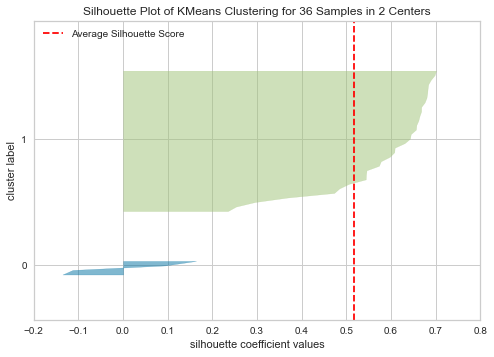

Silhouette score for 3  clusters:  0.3331948694503059


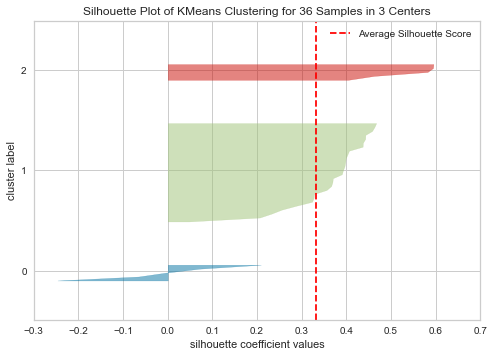

Silhouette score for 4  clusters:  0.37257530936886835


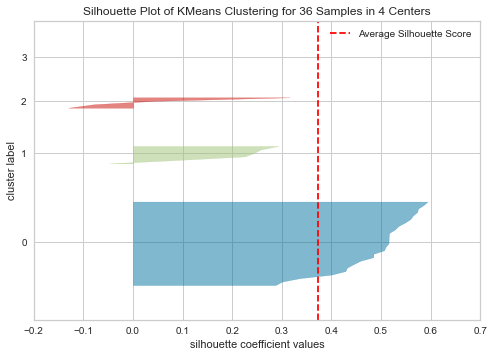

Silhouette score for 5  clusters:  0.3660632441177708


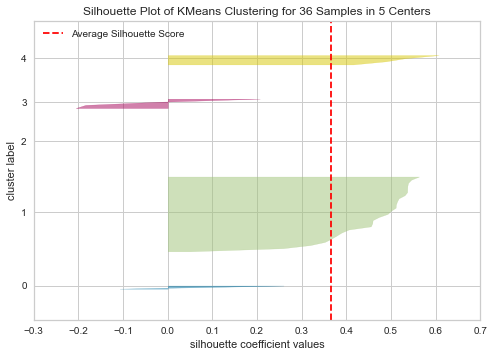

Silhouette score for 6  clusters:  0.4237635854795135


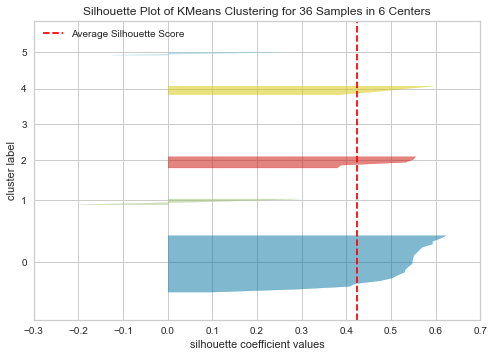

Silhouette score for 7  clusters:  0.4264250463972885


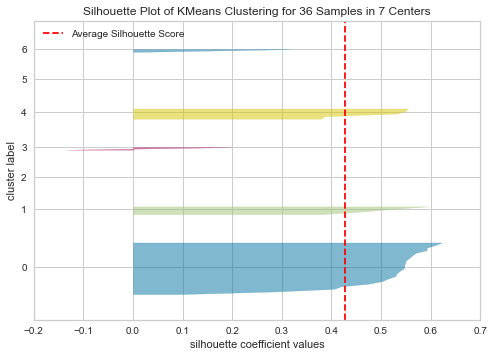

Silhouette score for 8  clusters:  0.4279642733500725


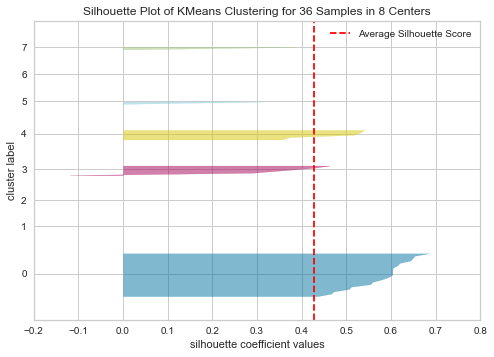

Silhouette score for 9  clusters:  0.29692502835672635


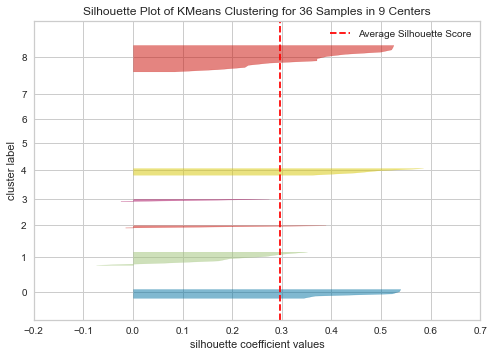

In [48]:
for n in range(2,10):
    model=KMeans(n_clusters=n, random_state=42)
    model.fit(view_scaled)
    preds=model.predict(view_scaled)
    score=metrics.silhouette_score(view_scaled, preds)
    print('Silhouette score for', n, ' clusters: ', score)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer = visualizer.fit(view_scaled)
    visualizer.show();

Silhouette score for 2  clusters:  0.6493318794638877


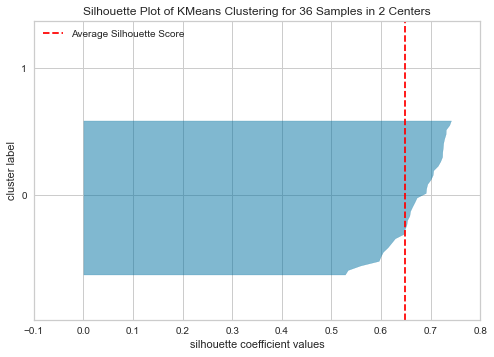

Silhouette score for 3  clusters:  0.20307335798060633


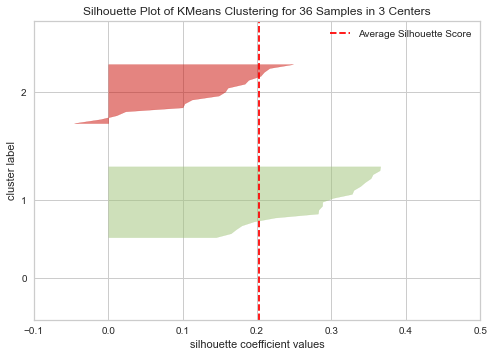

Silhouette score for 4  clusters:  0.2192374640175459


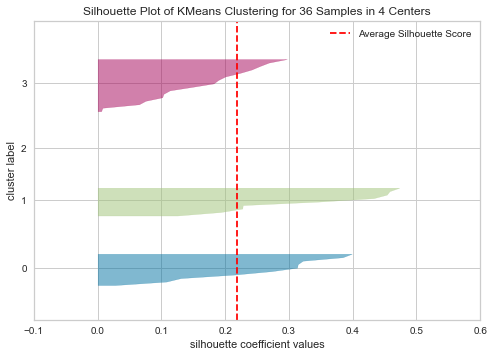

Silhouette score for 5  clusters:  0.32165271128131057


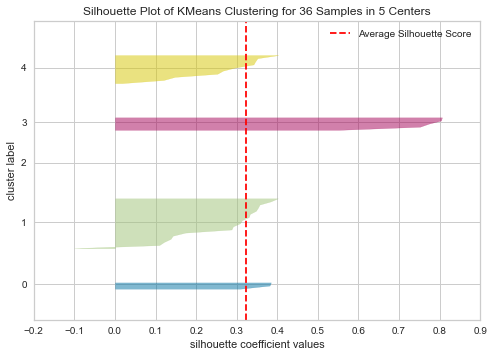

Silhouette score for 6  clusters:  0.31917017172284956


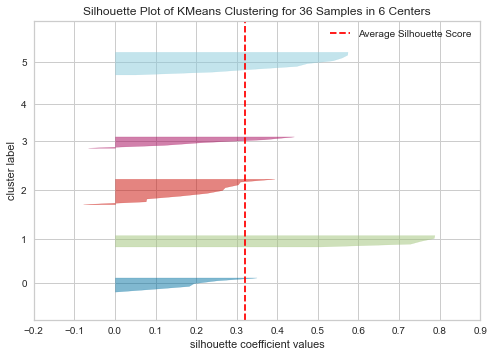

Silhouette score for 7  clusters:  0.3197699316237793


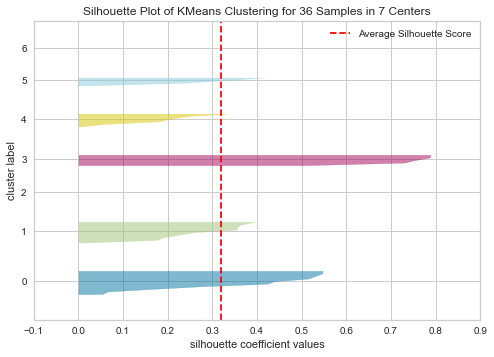

Silhouette score for 8  clusters:  0.31077865034320623


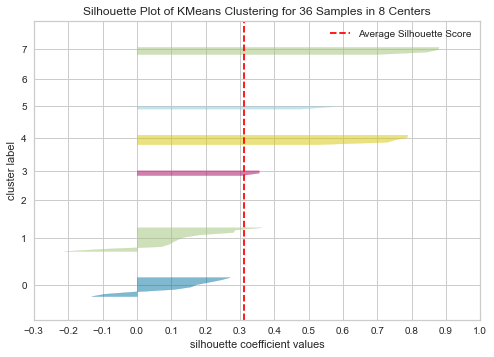

Silhouette score for 9  clusters:  0.3453337203948477


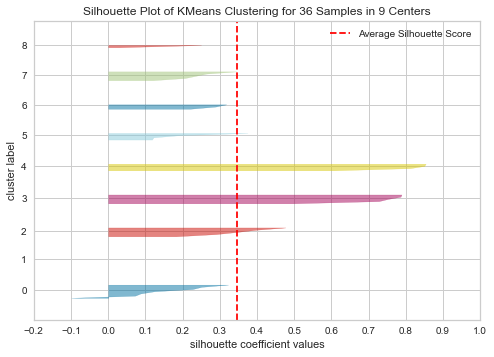

In [49]:
for n in range(2,10):
    model=KMeans(n_clusters=n, random_state=42)
    model.fit(session_scaled)
    preds=model.predict(session_scaled)
    score=metrics.silhouette_score(session_scaled, preds)
    print('Silhouette score for', n, ' clusters: ', score)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer = visualizer.fit(session_scaled)
    visualizer.show();

#### Elbow Method

The Elbow Method runs k-means clustering across a range of k’s, and then calculates the average distance of each data point to the centroid (the mean of the object’s cluster). In other words, this calculation is Within-Cluster-Sum of Squared Error (WSS).

The concept behind the elbow method is that the variation between data points will change rapidly for smaller values of k (clusters), and then will then slow as k continues to grow. Visually this looks like an elbow when plotted. The stronger the explained variation between data points in a cluster, the stronger their association is. Knowing this, the most optimal value of k is at the elbow.  

Below we will run the elbow method across a range of 2-10 k values, to determine what the optimal number of clusters is.

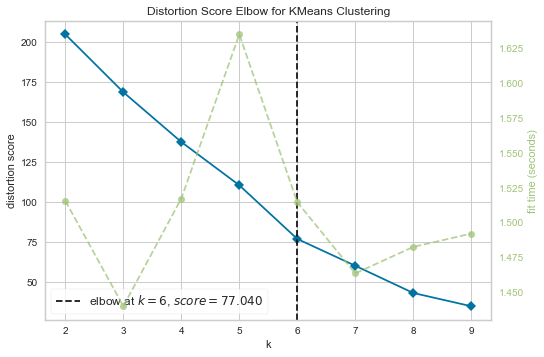

In [50]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(view_scaled)        
visualizer.show(); 

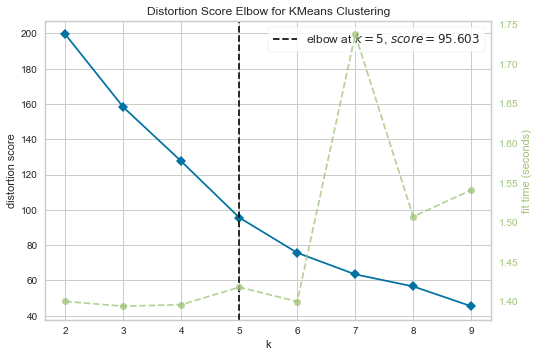

In [51]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(session_scaled)        
visualizer.show(); 

### Cluster and Centroid Visualizations

To visualize clusters, we will utilize PCA. PCA helps with visualization of data by reducing the dimensionality of the dataset.

Centroids should not overlap clusters.

#Note from Kellen - look at more dimensions

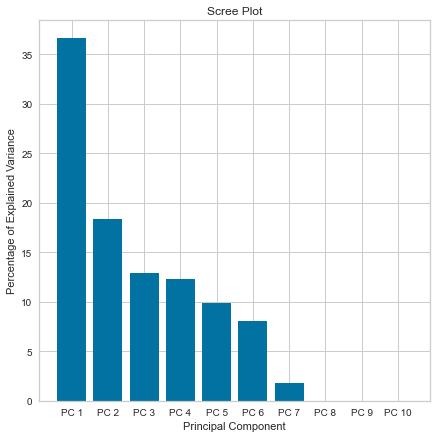

In [52]:
#for view_scaled dataframe
#view_scaled works a lot better than session_scaled for some reason

#scree plot
#we can see that several principal components have a significant impact here
#as a result our PCA graph will have a fair amount of skew

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA()
data_reduced = pca.fit_transform(view_scaled) 

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels=['PC '+ str(x) for x in range(1,len(per_var)+1)]

plt.figure(figsize=(7,7))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

In [53]:
#using k means to cluster our data
#using 2 clusters per silhouette scores

model = KMeans(n_clusters=2, random_state=42)
model.fit(view_scaled)
preds= model.fit_predict(view_scaled)

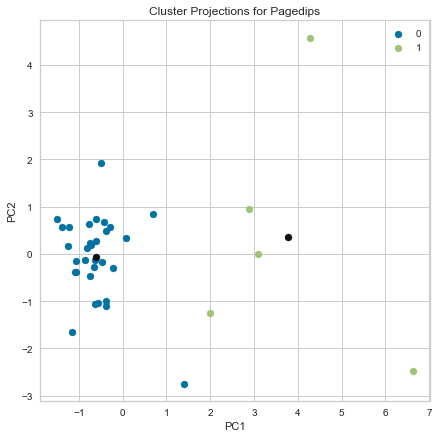

In [54]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

plt.figure(figsize=(7,7))

pca = PCA(n_components=6)
data_reduced = pca.fit_transform(view_scaled)

data_reduced = pca.fit_transform(view_scaled)
label = model.fit_predict(data_reduced)
centers = np.array(model.cluster_centers_)

cluster_pred = np.unique(label) 
for c in cluster_pred:
    plt.scatter(data_reduced[label == c , 0] , data_reduced[label == c , 1] , label = c)
plt.scatter(centers[:,0], centers[:,1], s=50, color='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cluster Projections for Pagedips')
plt.legend()
plt.show()

In [55]:
view_scaled.head()

,Events per session,Expandable Lists per session,Vidyards per session,Overlays per session,Binks per session,Tab-its per session,Length of session per session,Time in expandable list per session,Time in tab per session,Time in bink per session
0,-0.439496,-0.419011,-0.387542,-0.058162,0.323708,0.0,0.267909,-0.241575,-0.227756,0.0
1,0.543451,0.315129,3.961572,-0.884129,-0.401259,0.0,0.509317,1.608443,-0.563954,0.0
2,-0.688232,-0.485751,-0.387542,-0.884129,-0.401259,0.0,0.207597,-0.815222,-0.563954,0.0
3,-0.526574,-0.538587,-0.342239,0.642680,0.333247,0.0,0.264626,-0.524412,-0.563954,0.0
4,3.569875,3.919089,-0.387542,-0.884129,-0.401259,0.0,2.271363,4.538357,-0.563954,0.0


In [56]:
df.head()

,Pagedip ID,Unique Client session ID Views,Unique Client session ID,Views,Event,Expandable List interaction,Vidyard interaction,Overlay interaction,Bink interaction,Time in expandable list,Time in tab,Length of session,Time in bink,Time in overlay,slide interactions,tab interactions
0,01b8c260-7ace-11ec-8e94-4da5ae32c5b5,397,283,924,1857,1155,0,302,57,7298.807,33.494,12492.297175,0,-3.430177e+08,0.0,0.0
1,072045d0-8531-11ec-bb94-6d0f7bef74f7,1,1,1,6,4,1,0,0,33.374,0.000,29.689745,0,-1.290350e+06,0.0,0.0
2,07c80170-d618-11ec-a423-ddb76bf7a5d0,1,1,1,1,1,0,0,0,0.000,0.000,9.479948,0,-2.150584e+05,0.0,0.0
3,1830f120-89fb-11ec-a991-49176499f30b,47,20,96,159,77,1,58,6,384.429,0.000,1276.784921,0,-2.258106e+07,2.0,0.0
4,2c12f4f0-f64c-11ec-aa5b-bb98c69d4924,7,8,14,256,245,0,0,0,1032.067,0.000,2068.010538,0,-5.505494e+07,0.0,0.0


In [57]:
#bring cluster number into our dataframe and bringing Pagedip ID back in

view_scaled['cluster'] = preds

view_scaled['Pagedip ID'] = df['Pagedip ID']

df['cluster'] = preds

per_view['cluster'] = preds

per_view['Pagedip ID'] = df['Pagedip ID']

In [58]:
#bringing back in pagedip handles

handles = []

for a in view_scaled['Pagedip ID']:
    temp = mi.loc[mi['Pagedip ID'] == a]
    handles.append(temp.iloc[0]['Pagedip Handle'])

view_scaled['Pagedip Handle'] = handles
df['Pagedip Handle'] = handles
per_view['Pagedip Handle'] = handles

In [59]:
#creating a table of Pagedip ID, handle, and cluster

cluster_table = df[['Pagedip ID', 'Pagedip Handle', 'cluster']]

cluster_table.sort_values('cluster', inplace=True)

cluster_table.to_csv('cluster table.csv')

In [61]:
#summary stats for cluster 0 - raw data

df.loc[df['cluster'] == 0].describe().to_csv('cluster 0 raw.csv')

In [62]:
#summary stats for cluster 1 - raw data

df.loc[df['cluster'] == 1].describe().to_csv('cluster 1 raw.csv')

In [63]:
#summary stats for cluster 0 - normalized data

per_view.loc[per_view['cluster'] == 0].describe().to_csv('cluster 0 normalized.csv')

In [64]:
#summary stats for cluster 1 - normalized data

per_view.loc[per_view['cluster'] == 1].describe().to_csv('cluster 1 normalized.csv')

In [65]:
#summary stats for cluster 0 - scaled data

view_scaled.loc[view_scaled['cluster'] == 0].describe().to_csv('cluster 0 scaled.csv')

In [66]:
#summary stats for cluster 1 - scaled data

view_scaled.loc[view_scaled['cluster'] == 1].describe().to_csv('cluster 1 scaled.csv')

In [67]:
#df.to_csv('df.csv')
#per_view.to_csv('per_view.csv')
#view_scaled.to_csv('view_scaled.csv')

In [68]:
df.loc[df['cluster'] == 0]

,Pagedip ID,Unique Client session ID Views,Unique Client session ID,Views,Event,Expandable List interaction,Vidyard interaction,Overlay interaction,Bink interaction,Time in expandable list,Time in tab,Length of session,Time in bink,Time in overlay,slide interactions,tab interactions,cluster,Pagedip Handle
4,2c12f4f0-f64c-11ec-aa5b-bb98c69d4924,7,8,14,256,245,0,0,0,1032.067,0.0,2068.010538,0,-5.505494e+07,0.0,0.0,0,playbook-manual
22,98accaa0-89f0-11ec-bb94-6d0f7bef74f7,1,1,1,14,11,0,1,0,13.389,0.0,111.798273,0,-2.795755e+06,0.0,0.0,0,selling-online-for-b2b-businesses
28,b7c0a000-8ab9-11ec-a991-49176499f30b,1,1,1,10,9,0,0,0,36.912,0.0,-177.099936,0,-2.150584e+06,0.0,0.0,0,accelerate-sales-growth-with-actionable-data
33,e6e916f0-7b23-11ec-a218-7de02e5eae30,1,1,1,14,11,0,2,0,30.896,0.0,-247.939910,0,-2.580699e+06,0.0,0.0,0,automate-business-processes-with-ai


In [69]:
#getting lists that consists of the percentiles of per_view

events = list(per_view['Events per view'])

events_p = []

for a in per_view['Events per view']:
    events_p.append(stats.percentileofscore(events, a))
#
#stats.percentileofscore(events, a)
expandable_lists = list(per_view['Expandable Lists per view'])

expandable_lists_p = []

for a in per_view['Expandable Lists per view']:
    expandable_lists_p.append(stats.percentileofscore(expandable_lists, a))
#    
#
vidyard = list(per_view['Vidyards  per view'])

vidyard_p = []
#
#
for a in per_view['Vidyards  per view']:
    vidyard_p.append(stats.percentileofscore(vidyard, a))
#
#
overlay = list(per_view['Overlays per view'])

overlay_p = []

for a in per_view['Overlays per view']:
    overlay_p.append(stats.percentileofscore(overlay, a))
#
#
bink = list(per_view['Binks per view'])

bink_p = []

for a in per_view['Binks per view']:
    bink_p.append(stats.percentileofscore(bink, a))
#
#
tab = list(per_view['Tab-its per view'])

tab_p = []

for a in per_view['Tab-its per view']:
    tab_p.append(stats.percentileofscore(tab, a))
#    
#
los = list(per_view['Length of session per view'])

los_p = []

for a in per_view['Length of session per view']:
    los_p.append(stats.percentileofscore(los, a))
#
#
elt = list(per_view['Time in expandable list per view'])

elt_p = []

for a in per_view['Time in expandable list per view']:
    elt_p.append(stats.percentileofscore(elt, a))
#
#
tab_time = list(per_view['Time in tab per view'])

tab_time_p = []

for a in per_view['Time in tab per view']:
    tab_time_p.append(stats.percentileofscore(tab_time, a))
#
#
bink_time = list(per_view['Time in bink per view'])

bink_time_p = []

for a in per_view['Time in bink per view']:
    bink_time_p.append(stats.percentileofscore(bink_time, a))
    
views = list(df['Views'])

views_p = []

for a in df['Views']:
    views_p.append(stats.percentileofscore(views, a))


In [70]:
#turning lists into a dictionary

webster = {
    'Event':events_p,
    'Length of session': los_p,
    'Views': views_p,
    'Expandable List':expandable_lists_p,
    'Vidyard':vidyard_p,
    'Overlay':overlay_p,
    'Bink':bink_p,
    'Tabs': tab_p,
    'Time in expandable list': elt_p,
    'Time in tab': tab_time_p,
    'Time in bink': bink_time_p
}

#turning dictionary into a dataframe

view_p = pd.DataFrame(webster)

view_p['Pagedip ID'] = per_view['Pagedip ID']

view_p['Pagedip Handle'] = per_view['Pagedip Handle']

I don't feel that the clustering solution truly addresses Sherisse's desire for a proper Engagement Index.  Especially problematic is the fact that our 'standout' cluster consists of Pagedips with few views (in fact 3 out of 4 have only 1 view).  Without considering our data normalized to views we can't truly understand how much people are engaging with the Pagedip on a per-view basis, but without considering views we're not getting the full picture either.

My plan for creating an engagement index involves these three steps:

- Going back to our normalized data, returning a dataframe consisting of percentiles values of our normalized data.  Meaning for each row, we're going to fill in the percentile that value is for the entire column that is is within.  This puts each PageDip relative to the others like it, which has benefits.  It sets expectations relative to the traffic that a certain topic or Pagedip client expects.  It also has the benefit of returning exclusively values between 1 and 100, which is ideal for creating an index that people can understand.  Finally, it helps us learn more from the spread of our final index, once we get there. 

- Next, I create the index by using a weighted average of the percentiles in each row.  The weights that I use are subjective, and represent the importance that I place on certain inputs.  In the current iteration, I put a 20% weight on total views, events per view, and time on page per view, and 5% on expandable lists per view, vidyards per view, overlays per view, binks per view, tab its per view, time in expandable list per view, time in tab per view, and time in bink per view.  Again, these weights represent my subjective opinion on what is most important to PageDip and its clients, and those more informed than myself may have an entirely different opinion of what comprises engagement.

In [72]:
#given our new dataframe of percentile values, using weighted averages of the percentiles 

view_p['Engagement Index'] = (0.2 * view_p['Event']) + (0.2 * view_p['Views']) + (0.2 * view_p['Length of session']) + (0.05* view_p['Expandable List']) + (0.05 * view_p['Vidyard']) + (0.05 * view_p['Overlay']) + (0.05 * view_p['Bink']) + (0.05 * view_p['Tabs']) + (0.05 * view_p['Time in expandable list']) + (0.05 * view_p['Time in tab']) + (0.05 * view_p['Time in bink'])

In [73]:
view_p['Engagement Index'].describe()

count    36.000000
mean     51.388889
std      13.717765
min      22.430556
25%      43.940972
50%      49.444444
75%      62.291667
max      76.250000
Name: Engagement Index, dtype: float64

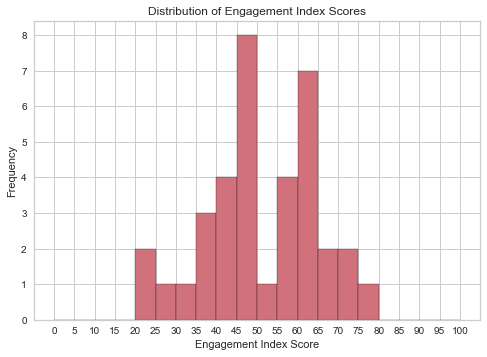

In [74]:
#plotting our engagement index scores in a histogram

b = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

plt.hist(view_p['Engagement Index'], bins=b, color = '#D1717B', edgecolor='black')
plt.xticks(b)
plt.title('Distribution of Engagement Index Scores')
plt.xlabel('Engagement Index Score')
plt.ylabel('Frequency')
plt.show()

In [75]:
view_p['Engagement Index'].describe().to_csv('engagement index description.csv')

In [76]:
#doing a shapiro wilks test for normality

stats.shapiro(view_p['Engagement Index'])

ShapiroResult(statistic=0.9618294835090637, pvalue=0.24465306103229523)

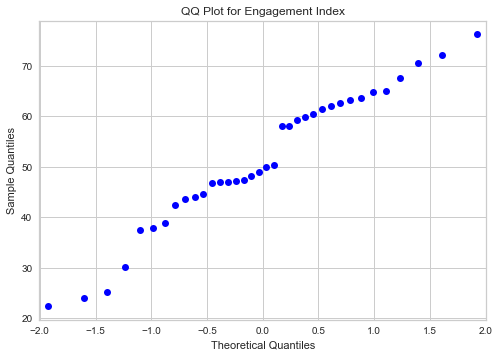

In [77]:
#making a QQ plot to look at normality of the data

fig = sm.qqplot(view_p['Engagement Index'])
plt.title('QQ Plot for Engagement Index')
plt.show()

In [79]:
#exporting our engagement index scores with pagedip id, pagedip handle, and percentiles

#view_p.sort_values('Engagement Index', ascending = False).to_csv('Pagedip Index Scores and Percentiles.csv')

#exporting engagement index scores with just identifying data

#view_p.sort_values('Engagement Index', ascending = False)[['Engagement Index', 'Pagedip ID', 'Pagedip Handle']].to_csv('Pagedip Index Scores.csv')

In [80]:
per_view.to_csv('per_view.csv')